Age > 0 => Crimes on Humans  
Years Considered: 2020-23  
Crimes Considered: Only top 10 types of Crimes

In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import plotly.express as px

Dataset Cleaning

In [66]:
# Load the data
crimeData = pd.read_csv('LA Crime Data.csv')

In [67]:
# List of columns to drop
colsToRemove = [
    'DR_NO', 'Date Rptd', 'Rpt Dist No', 'Part 1-2', 'Mocodes', 
    'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 
    'Crm Cd 4', 'LOCATION', 'Cross Street', 'Weapon Used Cd', 'Weapon Desc',
    'Premis Cd', 'Premis Desc','LAT', 'LON'
]

crimeDataCleaned = crimeData.drop(columns=colsToRemove)

In [68]:
# Convert DATE OCC to datetime and extract Month and Year
crimeDataCleaned['DATE OCC'] = pd.to_datetime(crimeDataCleaned['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
crimeDataCleaned['Year'] = crimeDataCleaned['DATE OCC'].dt.year
crimeDataCleaned['Month'] = crimeDataCleaned['DATE OCC'].dt.month

In [69]:
crimeDataCleaned.describe()

,DATE OCC,TIME OCC,AREA,Crm Cd,Vict Age,Year,Month
count,944235,944235.000000,944235.00000,944235.000000,944235.000000,944235.000000,944235.000000
mean,2022-03-22 01:21:52.136491776,1338.047956,10.72113,500.810848,29.499314,2021.744734,6.250125
min,2020-01-01 00:00:00,1.000000,1.00000,110.000000,-4.000000,2020.000000,1.000000
25%,2021-03-08 00:00:00,900.000000,6.00000,331.000000,0.000000,2021.000000,3.000000
50%,2022-04-09 00:00:00,1419.000000,11.00000,442.000000,30.000000,2022.000000,6.000000
75%,2023-04-10 00:00:00,1900.000000,16.00000,626.000000,45.000000,2023.000000,9.000000
max,2024-05-13 00:00:00,2359.000000,21.00000,956.000000,120.000000,2024.000000,12.000000
std,NaN,652.446103,6.09928,207.283501,21.882246,1.239839,3.490658


Fix TIME OCC

In [70]:
def correct_time_occ(time_occ):
    time_occ_str = str(time_occ)  # Convert to string for consistency
    length = len(time_occ_str)

    if length == 1:
        return f"0{time_occ_str}00"  # Single digit: prepend "0" and append "00"
    elif length == 2:
        return f"{time_occ_str}00"  # Two digits: append "00"
    elif length == 3:
        return f"0{time_occ_str}"  # Three digits: prepend "0"
    elif length == 4:
        return f"{time_occ_str}"  # Already in "HHMM" format, so return as is
    else:
        return time_occ_str  # Return as is for any other case

# Apply the function to correct TIME.OCC values
crimeDataCleaned['TIME OCC'] = crimeDataCleaned['TIME OCC'].apply(correct_time_occ)

# Extract the hour from the corrected TIME OCC values
crimeDataCleaned['hour'] = crimeDataCleaned['TIME OCC'].str[:2].astype(int)

In [71]:
# Filter out rows where Year is 2024
crimeDataCleaned = crimeDataCleaned[crimeDataCleaned['Year'] != 2024]

In [72]:
# Filter out rows where hour is greater than 23
crimeDataCleaned = crimeDataCleaned[crimeDataCleaned['hour'] <= 23]

In [73]:
# To ensure all columns have the right type assigned to it.

# Convert categorical columns to 'category' dtype
crimeDataCleaned['AREA'] = crimeDataCleaned['AREA'].astype('category')
crimeDataCleaned['Crm Cd'] = crimeDataCleaned['Crm Cd'].astype('category')
crimeDataCleaned['Vict Sex'] = crimeDataCleaned['Vict Sex'].astype('category')

# Convert numerical columns to 'float' or 'int' dtype if needed
crimeDataCleaned['Vict Age'] = crimeDataCleaned['Vict Age'].astype('int')  # if age can have decimal values; use int if only whole numbers
# crimeDataCleaned['LAT'] = crimeDataCleaned['LAT'].astype('float')
# crimeDataCleaned['LON'] = crimeDataCleaned['LON'].astype('float')
crimeDataCleaned['Year'] = crimeDataCleaned['Year'].astype('int')
crimeDataCleaned['Month'] = crimeDataCleaned['Month'].astype('int')
crimeDataCleaned['hour'] = crimeDataCleaned['hour'].astype('int')

# Display the data types to confirm the changes
print(crimeDataCleaned.dtypes)

DATE OCC        datetime64[ns]
TIME OCC                object
AREA                  category
AREA NAME               object
Crm Cd                category
Crm Cd Desc             object
Vict Age                 int64
Vict Sex              category
Vict Descent            object
Year                     int64
Month                    int64
hour                     int64
dtype: object


In [74]:
# This is where we filter out specific data to feed the model
# Filter data to only include records where Vict Age > 0
filtered_data = crimeDataCleaned[crimeDataCleaned['Vict Age'] > 0].copy()
# Step 2: Identify Top 10 Crime Types
top_10_crimes = filtered_data['Crm Cd'].value_counts().nlargest(10).index
filtered_data = filtered_data[filtered_data['Crm Cd'].isin(top_10_crimes)]

In [75]:
# Encode the target variable as category codes
filtered_data['Crm Cd'] = filtered_data['Crm Cd'].cat.codes

In [76]:
# Drop unnecessary columns
filtered_data = filtered_data.drop(columns=['DATE OCC', 'TIME OCC', 'AREA NAME', 'Crm Cd Desc', 'Year'])

In [77]:
# One-hot encode categorical columns
filtered_data = pd.get_dummies(filtered_data, columns=['AREA', 'Vict Sex', 'Vict Descent'], drop_first=True)

In [78]:
# Split the data into features (X) and target (y)
X = filtered_data.drop(columns=['Crm Cd'])
y = filtered_data['Crm Cd']

In [79]:
# Convert features to float32
X = X.astype('float32')

In [80]:
# One-hot encoding the target for neural networks
y_one_hot = to_categorical(y)

In [81]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_nn, y_test_nn = train_test_split(y_one_hot, test_size=0.2, random_state=42)

In [82]:
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.2%}")

Random Forest Accuracy: 19.46%


Random Forest Accuracy with LAT and LON: 26.19%  
Random Forest Accuracy without LAT and LON: 19.46%

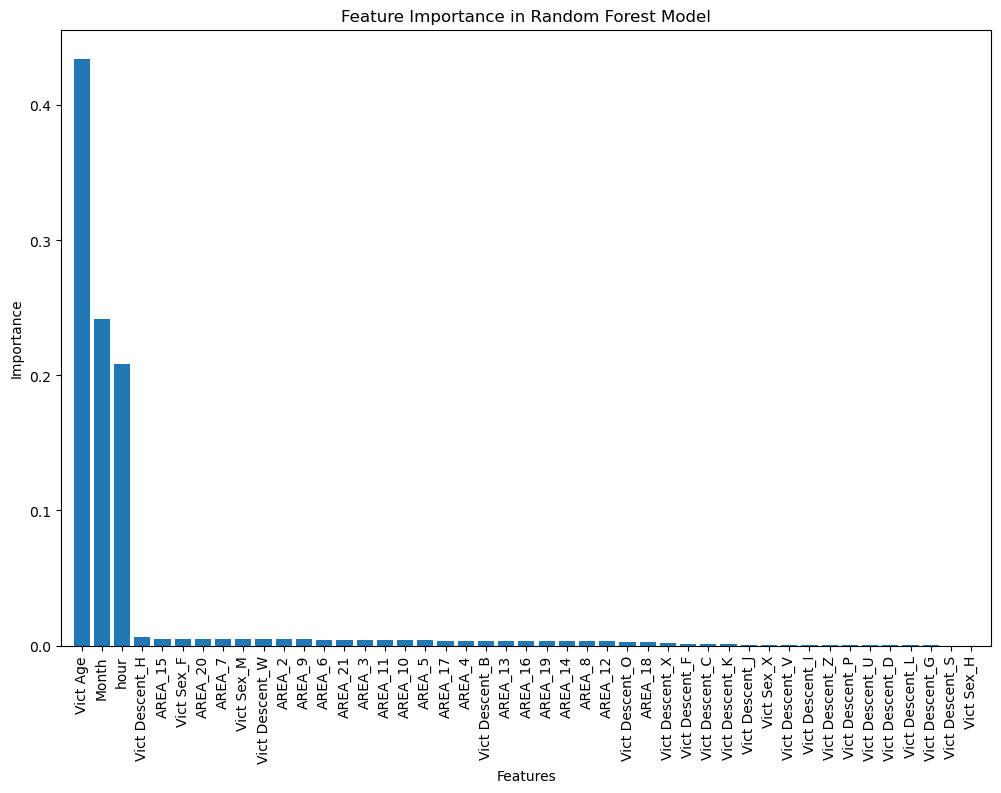

In [83]:
# # Get feature importances from the model
feature_importances = rf_model.feature_importances_

# # Sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# # Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importance in Random Forest Model")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [63]:
# Neural Network
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train_nn.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the neural network
history = model.fit(X_train, y_train_nn, epochs=50, validation_data=(X_test, y_test_nn), batch_size=128)

# Evaluate the neural network
nn_loss, nn_accuracy = model.evaluate(X_test, y_test_nn)
print(f"Neural Network Accuracy: {nn_accuracy:.2%}")

Epoch 1/50
2685/2685 [==============================] - 18s 6ms/step - loss: 2.1719 - accuracy: 0.2148 - val_loss: 2.1020 - val_accuracy: 0.2350
Epoch 2/50
2685/2685 [==============================] - 15s 5ms/step - loss: 2.0987 - accuracy: 0.2389 - val_loss: 2.0843 - val_accuracy: 0.2418
Epoch 3/50
2685/2685 [==============================] - 16s 6ms/step - loss: 2.0877 - accuracy: 0.2437 - val_loss: 2.0806 - val_accuracy: 0.2481
Epoch 4/50
2685/2685 [==============================] - 15s 6ms/step - loss: 2.0798 - accuracy: 0.2478 - val_loss: 2.0716 - val_accuracy: 0.2497
Epoch 5/50
2685/2685 [==============================] - 16s 6ms/step - loss: 2.0753 - accuracy: 0.2489 - val_loss: 2.0711 - val_accuracy: 0.2510
Epoch 6/50
2685/2685 [==============================] - 16s 6ms/step - loss: 2.0720 - accuracy: 0.2511 - val_loss: 2.0726 - val_accuracy: 0.2487
Epoch 7/50
2685/2685 [==============================] - 13s 5ms/step - loss: 2.0684 - accuracy: 0.2529 - val_loss: 2.0645 - val_ac

Neural Network Accuracy with LAT and LON: 26.50%.  
Neural Network Accuracy without LAT and LON: 27.06

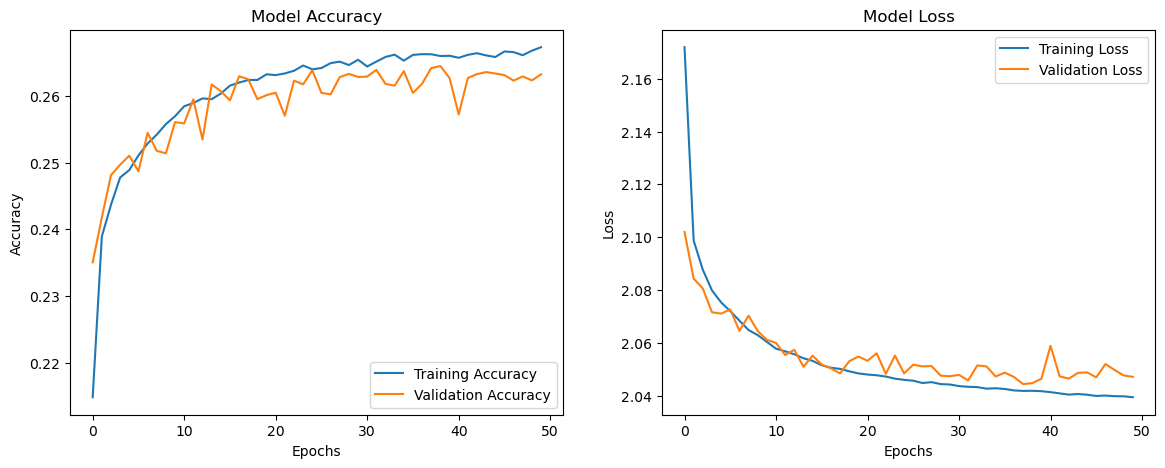

In [64]:
# Plot the accuracy and loss graphs
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search or Randomized Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=None, verbose=2)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.2%}")

# Evaluate on the test set
y_pred_rf = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {rf_accuracy:.2%}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  27.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  27.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  27.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  41.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  41.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  41.8s
[CV] END max_depth=10, min_s

KeyboardInterrupt: 

In [ ]:
# # Get feature importances from the model
feature_importances = best_rf.feature_importances_

# # Sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# # Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importance in Random Forest Model")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [ ]:
# # Define the model-building function
# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32),
#                     activation='relu', input_shape=(X_train.shape[1],)))
#     model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))

#     for i in range(hp.Int('num_layers', 1, 3)):
#         model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
#         model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

#     model.add(Dense(y_train_nn.shape[1], activation='softmax'))

#     model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # Initialize the tuner
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,  # Number of models to try
#     executions_per_trial=3,  # Number of times to train each model
#     directory='keras_tuner',
#     project_name='crime_type_prediction_nn')

# # Run the hyperparameter search
# tuner.search(X_train, y_train_nn, epochs=50, validation_data=(X_test, y_test_nn))

# # Get the best model
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Evaluate on the test set
# nn_loss, nn_accuracy = best_model.evaluate(X_test, y_test_nn)
# print(f"Neural Network Test Accuracy: {nn_accuracy:.2%}")

In [ ]:
# SVM Classifier
# svm_model = SVC(random_state=42)
# svm_model.fit(X_train, y_train)
# y_pred_svm = svm_model.predict(X_test)

# svm_accuracy = accuracy_score(y_test, y_pred_svm)
# print(f"SVM Accuracy: {svm_accuracy:.4f}")

In [ ]:
# Encoding categorical features
X = pd.get_dummies(X, drop_first=True)

# Initialize and train Random Forest model
model = RandomForestClassifier(class_weight='balanced')
model.fit(X, y)

# Predictions and evaluation
y_pred = model.predict(X)
print(classification_report(y, y_pred))